# Анализ результатов А/В-теста

Совместно  с отделом маркетинга был подготовлен список гипотез для увеличения выручки крупного интернет-магазина.


В ходе исследования мы:
- приоритизируем гипотезы
- запустим A/B-тест
- проанализируем результаты


Описание данных:



Файл **hypothesis.csv.**
- *Hypothesis* — краткое описание гипотезы;
- *Reach* — охват пользователей по 10-балльной шкале;
- *Impact* — влияние на пользователей по 10-балльной шкале;
- *Confidence* — уверенность в гипотезе по 10-балльной шкале;
- *Efforts* — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.


Файл **orders.csv.**
- *transactionId* — идентификатор заказа;
- *visitorId* — идентификатор пользователя, совершившего заказ;
- *date* — дата, когда был совершён заказ;
- *revenue* — выручка заказа;
- *group* — группа A/B-теста, в которую попал заказ.


Файл **visitors.csv.** 
- *date* — дата;
- *group* — группа A/B-теста;
- *visitors* — количество пользователей в указанную дату в указанной группе A/B-теста

### Импорт библиотек.

#### Импортируем библиотеки. Считаем данные из csv-файлов в датафреймы и сохраним в переменные

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import scipy.stats as stats

pd.set_option('display.max_colwidth', 0)

In [2]:
data = pd.read_csv('hypothesis.csv')
orders = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv')

### Предобработка данных.

#### Выведем общую информацию о таблицах и их типах данных. Проверим на наличие дубликатов.

In [3]:
data.info()
print('Количество явных дубликатов', data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
Количество явных дубликатов 0


In [4]:
visitors.info()
print('Количество явных дубликатов', visitors.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
Количество явных дубликатов 0


In [5]:
orders.info()
print('Количество явных дубликатов', orders.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
Количество явных дубликатов 0


#### Изменение типов данных.

Приведем даты в столбцах *date* таблиц **visitors и orders** к типу datetime64.

In [6]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [7]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

#### Переименование столбцов.
Переименуем столбцы таблицы **visitors**, приведем их к змеинному регистру.

In [8]:
orders=orders.rename(columns={'transactionId':'transaction_id','visitorId':'visitor_id'})

In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


В процессе предобработки данных не выявлено пропусков и явных дубликатов. Столбцы с данными о датах приведены к нужному типу для дальнейшего анализа. Названия столбцов приведены к змеинному регистру.

### Приоритезация гипотез.

#### Применим фреймворк ICE.

In [10]:
data['ICE'] = (data['Impact'] * data['Confidence'] / data['Efforts']).round(1)

data[['Hypothesis', 'ICE']].sort_values('ICE', ascending = False)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


#### Применим фреймворк RICE.

In [11]:
data['RICE'] = data['Reach'] * data['Impact'] * data['Confidence'] / data['Efforts']
data[['Hypothesis', 'RICE', 'ICE']].sort_values('RICE', ascending=False)

,Hypothesis,RICE,ICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0,11.2
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0,7.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0,13.3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0,8.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0,1.1
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0,2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0,1.3
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0,1.0


В пятерку приоритетных по ICE и RICE входят такие гипотезы как: 
1. Запустить акцию, дающую скидку на товар в день рождения
2. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
4. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
5. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

При использовании метода ICE гипотеза о запуске акции в День Рождения имеет максимальную оценку, но при приоритезации с использованием метода RICE данная гипотеза опустилась на пятое место. Это связано с показателем Reach, охват пользователей, которых затронет данное изменение минимальный.

### Анализ А/В-теста.

#### Общий анализ данных.

In [12]:
print('Количество уникальных пользователей совершивших заказ:', orders['visitor_id'].nunique())
print('Количество посетителей за период проведения теста:', visitors['visitors'].sum())
print('Кoличество заказов за период проведение теста:', orders['transaction_id'].count())

Количество уникальных пользователей совершивших заказ: 1031
Количество посетителей за период проведения теста: 37652
Кoличество заказов за период проведение теста: 1197


In [13]:
#Количество заказов в каждой группе
orders.groupby('group')['transaction_id'].count()

group
A    557
B    640
Name: transaction_id, dtype: int64

In [14]:
#Количество посетителей в каждой группе
visitors.groupby('group')['visitors'].sum()

group
A    18736
B    18916
Name: visitors, dtype: int64

В имеющихся у нас таблицах пердставлены данные о 1197 заказах от 1031 уникального пользователя. Посетителей во время проведение теста было 37652 человек из них 18736 в группе А и 18916 в группе В. Таким образов количество посетителей в группах практически одинаково. Число заказов в группе А значительно меньше чем в группе В и равно 557 и 640 соответственно.

In [15]:
#сформируем сводную таблицу по каждому пользователю с количеством заказов в каждой группе
data_pivot = orders.pivot_table(index = 'visitor_id', columns = 'group', values = 'transaction_id', aggfunc = 'count')
data_pivot = data_pivot.reset_index()
#переименуем столбцы id пользователя, кол-во заказов в группе A и в группе B
data_pivot.columns=['visitor_id', 'A', 'B']
#удалим пользователей, заказы которых попали тоолько в одну группу
data_pivot = data_pivot.dropna()
# выведем кол-во пользователей, заказы которых попали в обе группы
print('Количество пользователей, заказы который попали в обе группы:', len(data_pivot['visitor_id']))

#выведем кол-во заказов таких пользователей в группе А
print('Количество таких заказов в группе А:', data_pivot['A'].sum())
#выведем кол-во заказов таких пользователей в группе В
print('Количество таких заказов в группе B:', data_pivot['B'].sum())


Количество пользователей, заказы который попали в обе группы: 58
Количество таких заказов в группе А: 89.0
Количество таких заказов в группе B: 92.0


В данных встречается 58 пользователей(почти 6%), чьи заказы попали в обе группы теста. В общей сложности таких заказов было 181, по сегментам они поделены практически поровну, в группу А попало 89 заказов таких пользователей, а в группу В 92 заказа. Удаление таких пользователей из данных невозможно, так как у нас нет данных об уникальных посещениях этих пользователей (в таблице visitors нет id посетителей).

#### Подготовка данных для анализа.

 Создадим датафрейм **datesGroups** с уникальными парами значений 'date' и 'group', таблицы orders. Избавимся от дубликатов методом drop_duplicates().

In [16]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

Объявим переменную **ordersAggregated**, содержащую:

- дату;
- группу A/B-теста;
- число уникальных заказов в группе теста по указанную дату включительно;
- число уникальных пользователей, совершивших хотя бы 1 заказ в группе теста по указанную дату включительно;
- суммарную выручку заказов в группе теста по указанную дату включительно.

In [17]:
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

Аналогично  объявим переменную **visitorsAggregated**, содержащую:
- дату;
- группу A/B-теста;
- количество уникальных посетителей в группе теста по указанную дату включительно.

In [18]:
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

In [19]:
# объединяем кумулятивные данные в одной таблице и переименуем названия столбцов
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

#### График кумулятивной выручки по группам. 

Объявим переменные **cumulativeRevenueA и cumulativeRevenueB**, в которых сохраните данные о датах, выручке и числе заказов в группах A и B.
Построим графики кумулятивной выручки по дням и группам A/B-тестирования: 

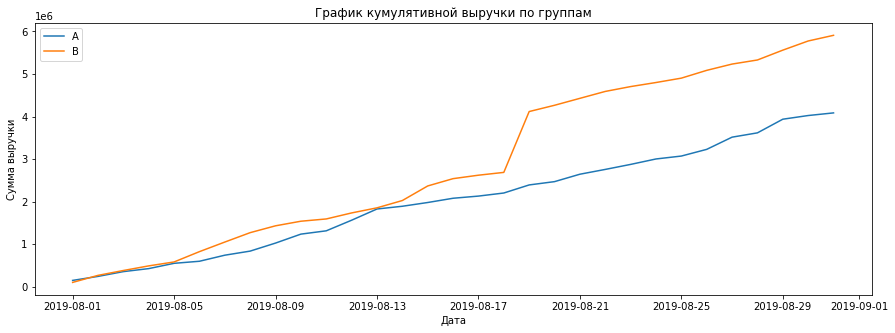

In [20]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Сумма выручки')
plt.gcf().set_size_inches(15, 5)
plt.legend();


Выручка сегмента А равномерно растет на протяжении всего теста. После 17.08.2019 выручка группы В резко увеличилась и продолжала расти до конца теста. Возможно аномально дорогие заказы повлияли на такой скачок выручки в середине теста.

#### График кумулятивного среднего чека по группам.

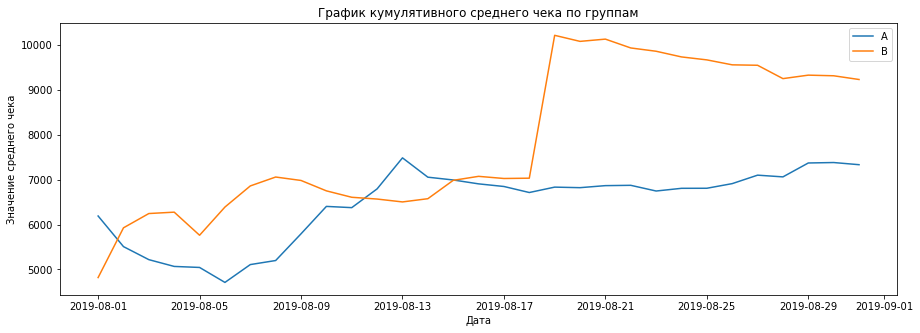

In [21]:
#разделим кумулятивную выручку на кумулятивное число заказов
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.gcf().set_size_inches(15, 5)
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Значение среднего чека')
plt.legend();

Значение среднего чека неравномерно у обеих групп первую половину теста. После 17.08.2019 показатель стал стабильным для сегмента А, а в группе В наблюдается резкий скачок с дальнейшим падением значения. Возможно в сегмент В попали крупные заказы, тогда ему нужно больше времени прийти к реальному среднему чеку, либо требуется дополнительный анализ на выбросы, которые сильно искажают результаты.

#### График относительного изменения кумулятивного среднего чека группы B к группе A. 

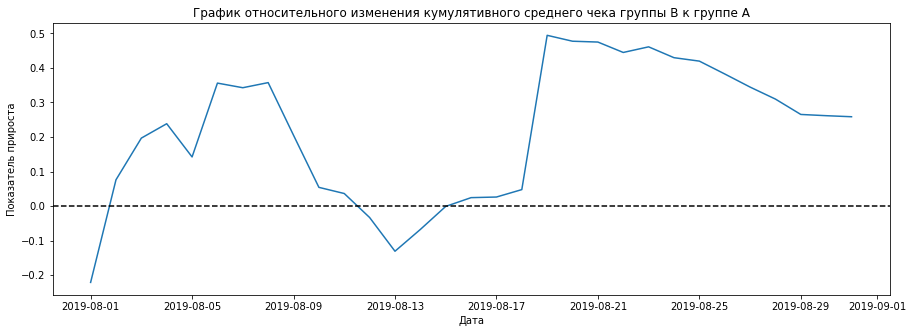

In [22]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', 
                                                   suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Показатель прироста')
plt.gcf().set_size_inches(15, 5)


На основании графика можно сделать вывод, что результаты теста значительно и резко менялисть в несколько дат. Видимо в эти дни были совершены аномальные заказы.

#### График кумулятивного среднего количества заказов на посетителя по группам.

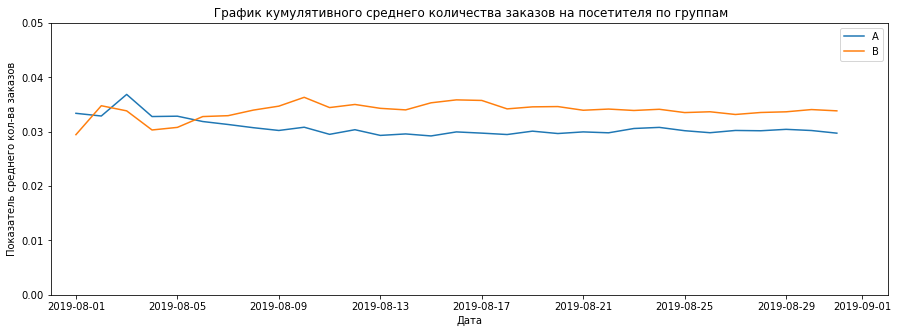

In [23]:
# считаем кумулятивное среднее количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.gcf().set_size_inches(15, 5)
plt.title(' График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Показатель среднего кол-ва заказов')
# задаем масштаб осей
plt.axis([dt.datetime(2019, 7, 31), dt.datetime(2019, 9, 2), 0, 0.05]);

Значение показателя среднего количества заказов довольно быстро зафиксировалось в обоих сегментах около своего среднего значения. Среднее количество заказов группы В чуть выше чем в А.

#### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

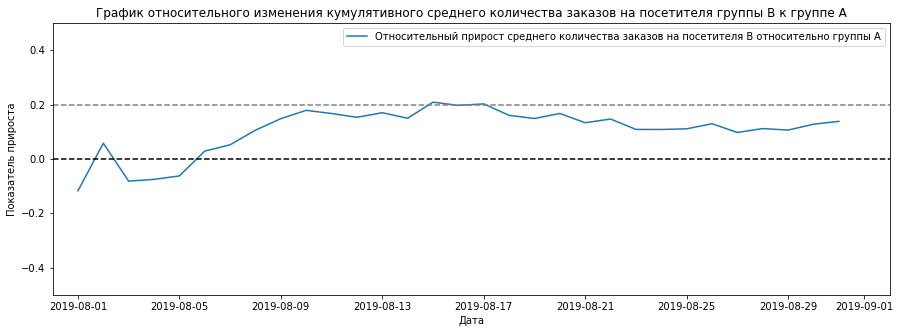

In [24]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], 
                                                                           left_on='date', right_on='date', how='left', 
                                                                           suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1,
         label="Относительный прирост среднего количества заказов на посетителя В относительно группы A"
         )
plt.legend()
plt.gcf().set_size_inches(15, 5)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Показатель прироста')
plt.axis([dt.datetime(2019, 7, 31), dt.datetime(2019, 9, 2), -0.5, 0.5]);

Почти с начала теста и до его середины группа В лидировала по среднему количеству заказов на посетителя и наращивала свой показатель. После 17.08.2019 показатель сегмента В слегка просел и зафиксировался в районе 10%.

#### Точечный график количества заказов по пользователям.

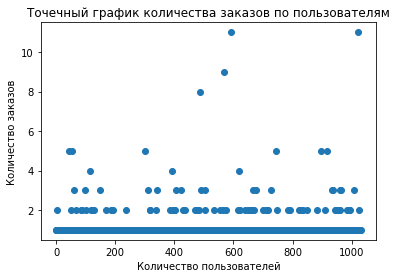

In [25]:
#Найдем число заказов по пользователям
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns = ['visitor_id', 'orders']

# построим точечную диаграмму числа заказов на пользователя
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('Количество пользователей')
plt.ylabel('Количество заказов')
plt.scatter(x_values, ordersByUsers['orders']);

Большинство покупателей заказывали только один раз. Однако доля пользователей с 2-3 заказами тоже значительна. Есть редкие случаи пользователей с заказами более 5. Возможно их можно считать аномальными.

#### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. 

In [26]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

Не более 5% пользователей оформляли больше чем 2 заказа. И всего 1% пользователей заказывали более четырех раз. 
За верхнюю границу числа заказов можно выбрать 2 заказа на одного пользователя.

#### Точечный график стоимостей заказов. 

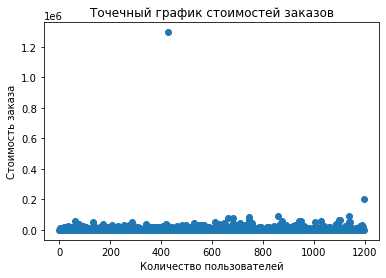

In [27]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Количество пользователей')
plt.ylabel('Стоимость заказа')
plt.scatter(x_values, orders['revenue']); 

Большая доля заказов в границе до 60 000. Но на графике видны аномальные редкие значения в 200 000 и 1 300 000. Построим график, исключив выбросы в виде стоимости заказа свыше 200 000 для большей информативности.

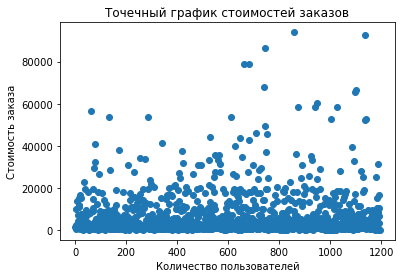

In [28]:
orders_new = orders[orders['revenue']<200000]
x_values = pd.Series(range(0, len(orders_new['revenue'])))
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Количество пользователей')
plt.ylabel('Стоимость заказа')
plt.scatter(x_values, orders_new['revenue']);

Большая доля заказов в границе до 20 000, реже встречаются заказы стоимостью от 20 000 до 40 000. Заказы свыше 50 000 встречаются крайне редко.

#### Посчитаем 95-й и 99-й перцентили стоимости заказов. 

In [29]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Не более 5% заказов дороже 28 000 и не более 1% дороже 58 233,20. За верхнюю границу стоимости заказов стоит выбрать 28 000.

#### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

Сформулируем гипотезы. 
1. Нулевая: различий в среднем количестве заказов между группами нет. 
2. Альтернативная: различия в среднем между группами есть.

Уровень статистической значимости установим в размере 0.05.

Подготовим данные. Создадим таблицу date с данными о количестве и сумме заказа за день, а так же с накопленным количеством и суммой заказов включая дату.

In [30]:
#создадим таблицу с данными о дате и количестве посетителей в день по группе А
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
#создадим таблицу комулятивного количества пользователей по группе А
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']


#создадим таблицу с данными о дате и количестве посетителей в день по группе В
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']
#создадим таблицу комулятивного количества пользователей по группе А
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# группируем данные по заказам группы А, количество заказов в день и их выручка
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']
#создадим таблицу комулятивного количества заказов и сумм выручки по группе А
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]


# группируем данные по заказам группы В, количество заказов в день и их выручка
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']
#создадим таблицу комулятивного количества заказов и сумм выручки по группе В
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

In [31]:
#Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. 
#В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']


In [32]:
#Создадим переменные sampleA и sampleB, в которых пользователям с заказами будет соответствовать число заказов пользователя. 
#А пользователям без заказов — нули.
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
#Применим критерий «U-критерий Манна-Уитни» и посчитаем статистическую значимость различия среднего количества заказов
print('P-value:', "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
# Расчитаем относительный прирост среднего числа заказов группы B
print('Относительный прирост среднего группы В к А:', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))


P-value: 0.017
Относительный прирост среднего группы В к А: 0.138


Статистическая значимость (p-value) значительно меньше 5%, значит нулевую гипотезу отвергаем. Анализ "сырых данных" показывает, что в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы В к среднему количеству заказов в группе А равен 13,8%.

#### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 

Сформулируем гипотезы:
1. Нулевая гипотеза: различий в среднем чеке между группами нет. 
2. Альтернативная гипотеза: различия в среднем чеке между группами есть. 

Уровень статистической значимости установим в размере 0.05.

In [33]:
print('P-value:','{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                                     orders[orders['group']=='B']['revenue'])[1]))
print('Относительный прирост среднего группы В к А:', 
      '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean() / orders[orders['group']=='A']['revenue'].mean()-1))

P-value: 0.729
Относительный прирост среднего группы В к А: 0.259


Статистическая значимость (p-value) значительно больше 5%, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Однако относительный прирост в группе В по отошению к сегменту А равен почти 26%.

#### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. 

Сформулируем гипотезы:
1. Нулевая гипотеза: различий в среднем количестве заказов на поситителя по "очищенным" данным между группами нет. 
2. Альтернативная гипотеза: различия в среднем количестве заказов на поситителя по "очищенным" данным между группами есть. 

Уровень статистической значимости установим в размере 0.05.



Примем за аномальных пользователей тех, кто совершил от 3 заказов или совершил заказ дороже 28 000 рублей. Так мы уберём 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 2 — **usersWithManyOrders** и пользователей, совершивших заказы дороже 28 000 — **usersWithExpensiveOrders**. Объединим их в таблице **abnormalUsers**. 

In [34]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0]) 

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
dtype: int64
74


In [35]:
#Создадим переменные sampleAFiltered и sampleBFiltered, в которых сохраните очищенные данные о заказах — не включая аномальных 
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
#Применим критерий «U-критерий Манна-Уитни» и посчитаем статистическую значимость различия среднего количества заказов
print('Уровень статистической значимости(p-value):', '{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
# Расчитаем относительный прирост среднего числа заказов группы B
print('Относительный прирост среднего числа заказов группы В к А:', 
      '{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))



Уровень статистической значимости(p-value): 0.013
Относительный прирост среднего числа заказов группы В к А: 0.173


Как и в случае с "сырыми" данными показатель статистической значимости меньше 5%,значит нулевую гипотезу отвергаем. Анализ "очищенных данных" так же показывает, что в среднем количестве заказов между группами есть статистически значимые различия. Показатели среднего количества заказов в группе В так же лучше, чем в группе А.


#### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 


Сформулируем гипотезы:
1. Нулевая гипотеза: различий в среднем чеке заказа по "очищенным" данным между группами нет. 
2. Альтернативная гипотеза: различия в среднем чеке заказа по "очищенным" данным между группами есть. 

Уровень статистической значимости установим в размере 0.05.

In [36]:
print(
    'Уровень статистической значимости(p-value):',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    'Относительный прирост среднего числа заказов группы В к А:',
    '{0:.3f}'.format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)




Уровень статистической значимости(p-value): 0.738
Относительный прирост среднего числа заказов группы В к А: -0.020


По результату теста выводы о статистической значимости не изменились, в среднем чеке нет различий между группами. Но показатель относительного прироста дал отрицательный результат. Средний чек в сегменте В значительно ниже чем в группе А.

### Вывод.


1. Есть статистически значимое различие по среднему количеству заказов между группами как по «сырым», так и по данным после фильтрации аномалий;
2. Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
3. График кумулятивного среднего количества заказов на посетителя по группам сообщает, что результаты группы B лучше группы A: показатели зафиксировались около среднего значения во второй половине теста.
4. График различия среднего чека колеблется, за счет выбросов в виде аномально больших значений чека в середине теста. Но показатель стабилизировался и медленно снижается во второй половине теста и зафиксировался в районе 30%.

Тест можно остановить. Количество заказов в группе В увеличилось по сравнению с группой А. Но статистически значимого различия по среднему чеку между группами нет.